# Loading data

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!cp "drive/My Drive/preprocessing_tools.py" .

In [43]:
!pip install razdel
!pip install pymorphy2

In [44]:
!cp "drive/My Drive/stopwords.txt" .

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import probplot
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression
from scipy import sparse
import lightgbm as lgb
import preprocessing_tools as pr
import plotly
import cufflinks as cf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import gc

color = sns.color_palette()

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

%matplotlib inline

In [46]:
raw_data = pd.read_csv('/content/drive/My Drive/clear_dataset.csv', index_col=0, parse_dates=True, encoding='UTF-8')
raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212699 entries, 2006-10-24 20:49:00 to 2019-06-26 08:15:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tittle  212699 non-null  object
 1   text    212699 non-null  object
 2   rate    212699 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.5+ MB


,tittle,text,rate
date,,,
2006-10-24 20:49:00,В США и России размещено больше всего сайтов с...,Организация Internet Watch Foundation в ходе ...,0
2006-11-30 12:07:00,«Цифровой раздел» между поколениями увеличивается,"21% американских родителей уверены в том, что...",-2
2006-09-05 08:32:00,Результаты Yahoo Answers вошли в основную выда...,Флагман социального поиска в интернете Yahoo ...,0
2006-07-01 21:45:00,«Артон консалтинг» исследовала контекстную рек...,Компания «Артон консалтинг» опубликовала иссл...,0
2007-01-19 11:14:00,Внутренний голос в RSS,У меня вот какая бяка постоянно вылезает. Есл...,0


# 1. Preprocessing

In [47]:
# проверка пропущенных значений (в данном случае их нет)
print('Shape: ', raw_data.shape)
print('Shape after dropping nan values: ', raw_data.dropna().shape)
columns = ['title', 'text', 'rate']
raw_data.columns = columns

Shape:  (212699, 3)
Shape after dropping nan values:  (212699, 3)


In [48]:
raw_data.tail()

,title,text,rate
date,,,
2019-06-27 07:38:00,Продакт-менеджер здорового человека,Каких менеджеров любят дизайнеры в продуктовы...,3
2019-06-26 07:51:00,"EA заявила, что лутбоксы — это «довольно этичн...",На заседании комитета парламента Великобрит...,13
2019-06-27 08:09:00,Дайджест событий для HR-специалистов в сфере I...,Июль — самое время запланировать путешеств...,11
2019-06-26 08:04:00,Минимальная установка CentOS/Fedora/RedHat,"Не сомневаюсь, что благородные доны — админис...",7
2019-06-26 08:15:00,Счетная палата РФ открывает свои исходные коды,Счетная палата выходит на новый уровень пр...,16


## 1.1. Feature engineering



In [49]:
%%time
raw_data['weekday'] = raw_data.index.weekday
raw_data['year'] = raw_data.index.year
raw_data['month'] = raw_data.index.month
raw_data['hour'] = raw_data.index.hour
raw_data['text_lenght'] = raw_data.text.apply(len)

CPU times: user 213 ms, sys: 1.86 ms, total: 215 ms
Wall time: 215 ms


In [50]:
raw_data.head()

,title,text,rate,weekday,year,month,hour,text_lenght
date,,,,,,,,
2006-10-24 20:49:00,В США и России размещено больше всего сайтов с...,Организация Internet Watch Foundation в ходе ...,0,1,2006,10,20,772
2006-11-30 12:07:00,«Цифровой раздел» между поколениями увеличивается,"21% американских родителей уверены в том, что...",-2,3,2006,11,12,658
2006-09-05 08:32:00,Результаты Yahoo Answers вошли в основную выда...,Флагман социального поиска в интернете Yahoo ...,0,1,2006,9,8,564
2006-07-01 21:45:00,«Артон консалтинг» исследовала контекстную рек...,Компания «Артон консалтинг» опубликовала иссл...,0,5,2006,7,21,1524
2007-01-19 11:14:00,Внутренний голос в RSS,У меня вот какая бяка постоянно вылезает. Есл...,0,4,2007,1,11,255


# 2. Exploratory data analysis


## 2.1. Target Variable

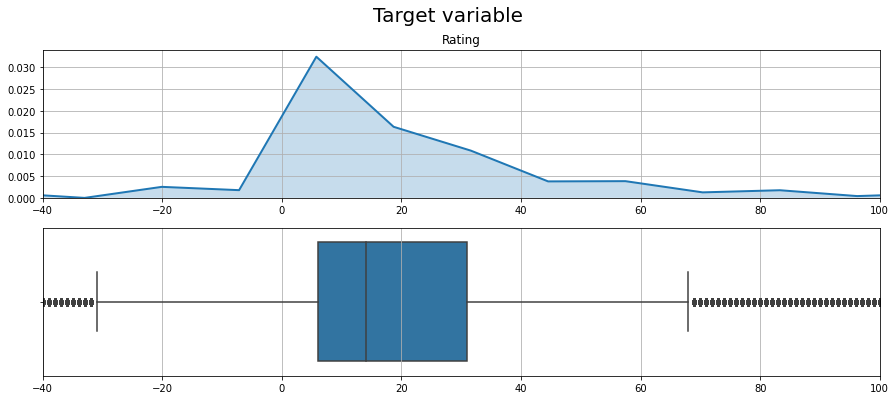

In [51]:
plt.figure(figsize=(15,6))
plt.suptitle("Target variable",fontsize=20)
gridspec.GridSpec(1,2)

plt.subplot2grid((2,2),(0,0), colspan = 2)
plt.xlim(-40, 100)
sns.distplot(raw_data.rate.values, hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.grid(True)
plt.title("Rating")

plt.subplot2grid((2,2),(1,0), colspan = 2)
plt.xlim(-40, 100)
plt.grid(True)
sns.boxplot(raw_data.rate.values)


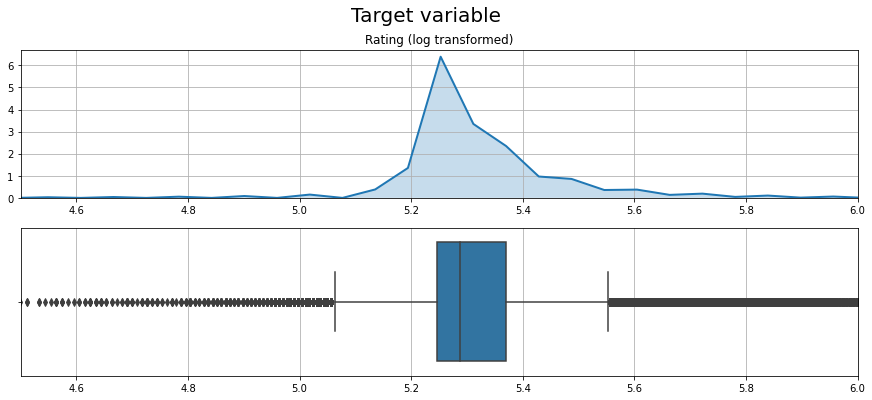

In [52]:
min_rate = raw_data.rate.values.min()
plt.figure(figsize=(15,6))
plt.suptitle("Target variable",fontsize=20)
gridspec.GridSpec(2,2)

plt.subplot2grid((2,2),(0,0), colspan = 2)
plt.xlim(4.5, 6)
sns.distplot(np.log1p(raw_data.rate.values + abs(min_rate)), hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.grid(True)
plt.title("Rating (log transformed)")

plt.subplot2grid((2,2),(1,0), colspan = 2)
plt.xlim(4.5, 6)
plt.grid(True)
sns.boxplot(np.log1p(raw_data.rate.values + abs(min_rate)))


##2.2. Time series features

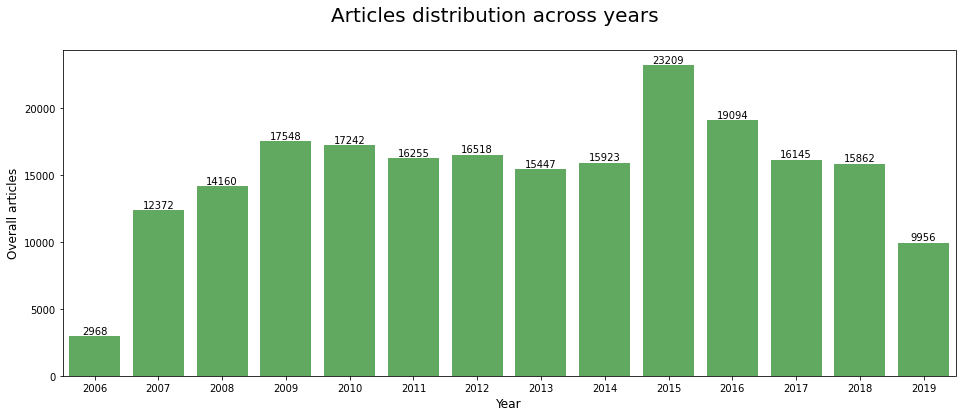

In [53]:
plt.figure(figsize=(16,6))
plt.suptitle("Articles distribution across years",fontsize=20)

ax1 = sns.countplot(x='year', data=raw_data, alpha=0.8, color=color[2])
plt.ylabel('Overall articles', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(False)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

In [54]:
subsample = raw_data[raw_data.year >= 2016]

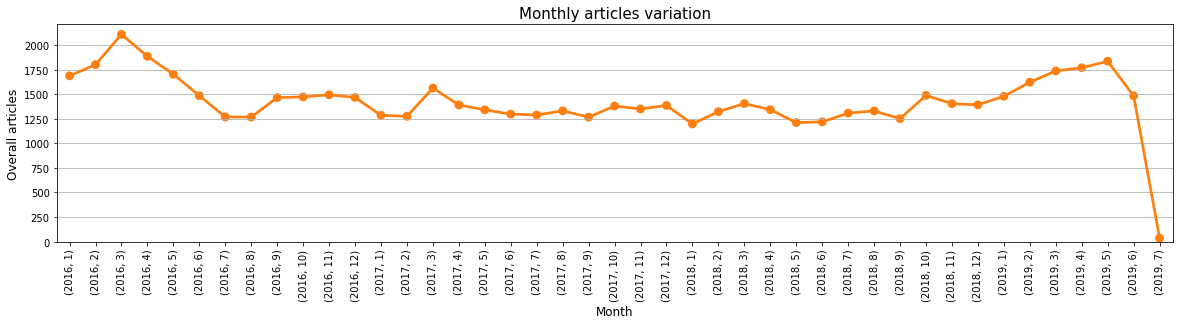

In [55]:
temp=subsample.groupby(['year','month'])['hour'].count()
plt.figure(figsize=(20,4))
sns.pointplot(temp.index,temp.values, alpha=0.8, color=color[1])
plt.grid(True, axis='y')
plt.ylim(0)
plt.ylabel('Overall articles', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Monthly articles variation', fontsize=15)
plt.xticks(rotation='vertical');

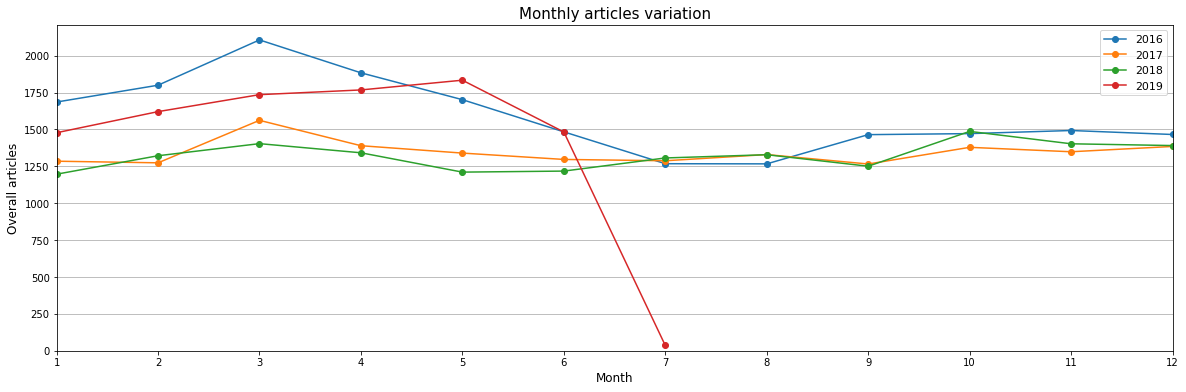

In [ ]:
temp=subsample.groupby(['year','month']).aggregate({'hour':np.size,'year':np.min,'month':np.min})
temp.reset_index(drop=True, inplace=True)
plt.figure(figsize=(20,6))
plt.plot(range(1,13),temp.iloc[0:12,0],label="2016", marker='o')
plt.plot(range(1,13),temp.iloc[12:24,0],label="2017", marker='o')
plt.plot(range(1,13),temp.iloc[24:36,0],label="2018", marker='o')
plt.plot(range(1,8),temp.iloc[36:43,0],label="2019", marker='o')
plt.grid(True, axis='y')
plt.ylim(0)
plt.ylabel('Overall articles', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Monthly articles variation', fontsize=15)
plt.xticks(np.arange(1, 13, 1.0))
plt.xlim(1, 12)
plt.legend(loc='upper right', fontsize=11)
plt.xticks(rotation='horizontal');

Как можно видеть, наибольшее число статей публикуется в первой половине года.


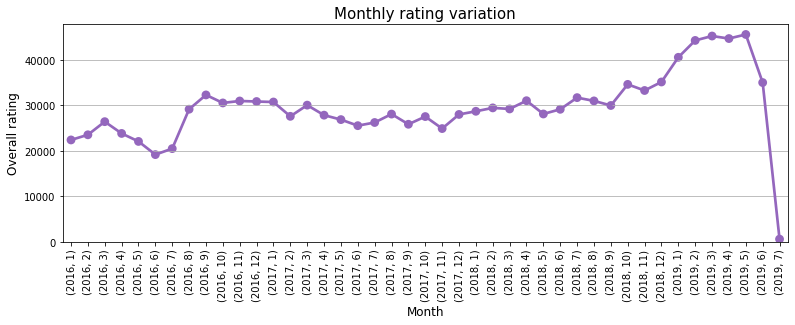

In [ ]:
temp=subsample.groupby(['year','month'])['rate'].sum()
plt.figure(figsize=(13,4))
sns.pointplot(temp.index,temp.values, alpha=0.8, color=color[4],)
plt.grid(True, axis='y')
plt.ylim(0)
plt.ylabel('Overall rating', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Monthly rating variation', fontsize=15)
plt.xticks(rotation='vertical');

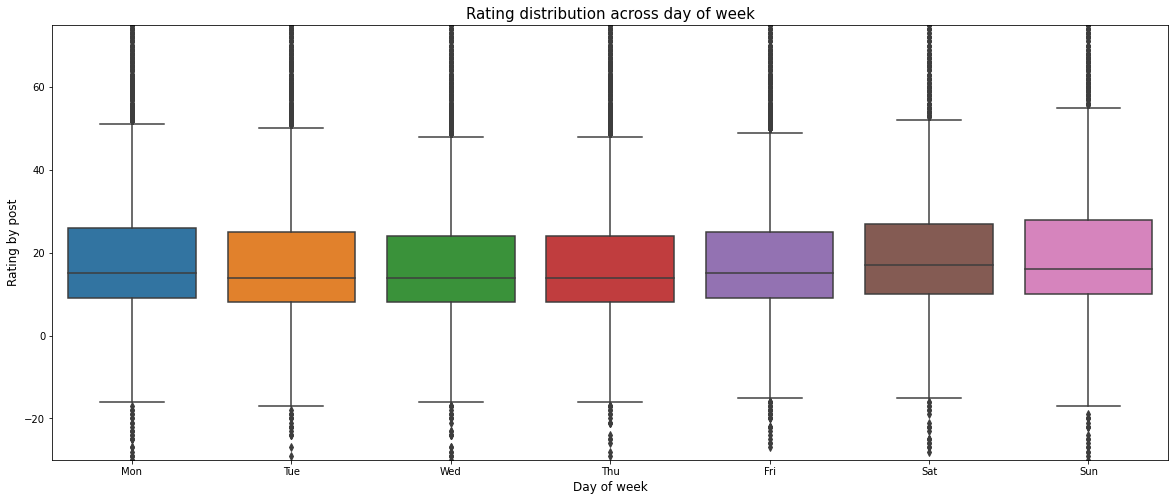

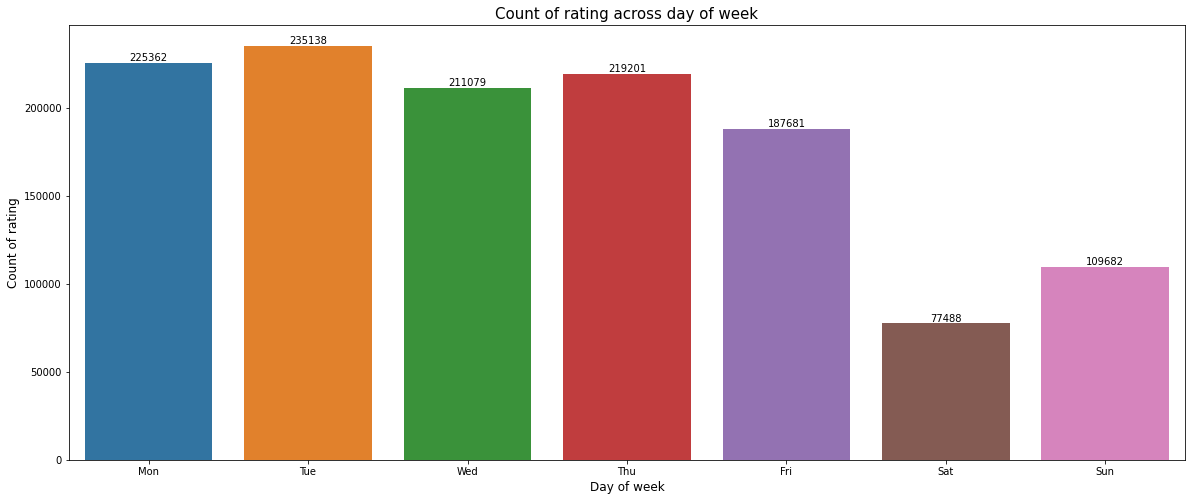

In [ ]:
plt.figure(figsize=(20,8))

#plt.subplot(121)
ax1 = sns.boxplot(y='rate',x='weekday', data=subsample)
plt.ylim(-30,75)
plt.ylabel('Rating by post', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title('Rating distribution across day of week', fontsize=15)
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


plt.figure(figsize=(20,8))
#plt.subplot(122)
temp = subsample.groupby('weekday')['rate'].sum()
ax2 = sns.barplot(temp.index,np.round(temp.values))
plt.ylabel('Count of rating', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title('Count of rating across day of week', fontsize=15)
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{}'.format(int(p.get_height())), (x.mean(), y), ha='center', va='bottom');

Наибольший суммарный рейтинг приходится на статьи, опубликованные в первой половине недели, а наименьший суммарный рейтинг - на статьи, опубликованные в конце недели. 

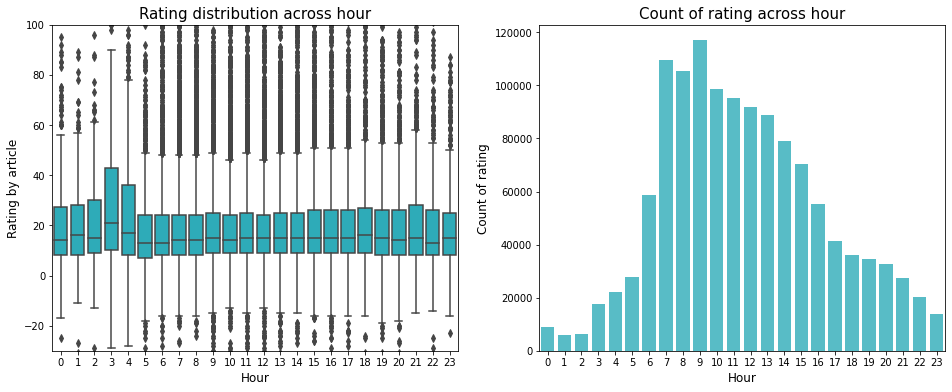

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(121)
ax1 = sns.boxplot(y='rate',x='hour', data=subsample, color=color[9])
plt.ylim(-30,100)
plt.ylabel('Rating by article', fontsize=12)
plt.xlabel('Hour', fontsize=12)
plt.title('Rating distribution across hour', fontsize=15)

plt.subplot(122)
temp = subsample.groupby('hour')['rate'].sum()
ax2 = sns.barplot(temp.index,temp.values, alpha=0.8, color=color[9])
plt.ylabel('Count of rating', fontsize=12)
plt.xlabel('Hour', fontsize=12)
plt.title('Count of rating across hour', fontsize=15);

Наибольший суммарный рейтинг набирают статьи, опубликованные в утренние часы, минимум приходится на статьи, опубликованные ночью.

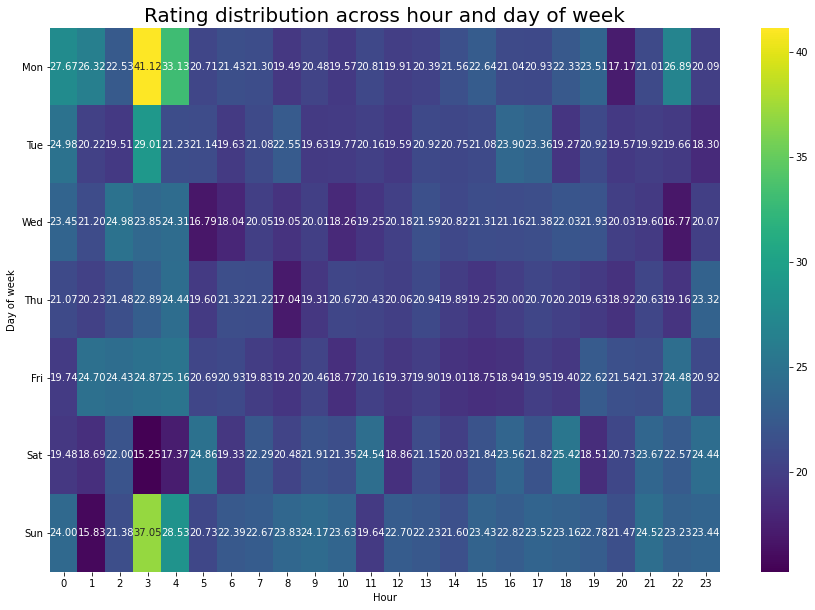

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Rating distribution across hour and day of week', fontsize=20)
temp = subsample.pivot_table(index='weekday', columns='hour', values='rate', aggfunc='mean')
ax = sns.heatmap(temp, annot=True, fmt='.2f', cmap='viridis')
ax.set(xlabel='Hour', ylabel='Day of week')
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks(rotation='horizontal');

## 2.3. Other features

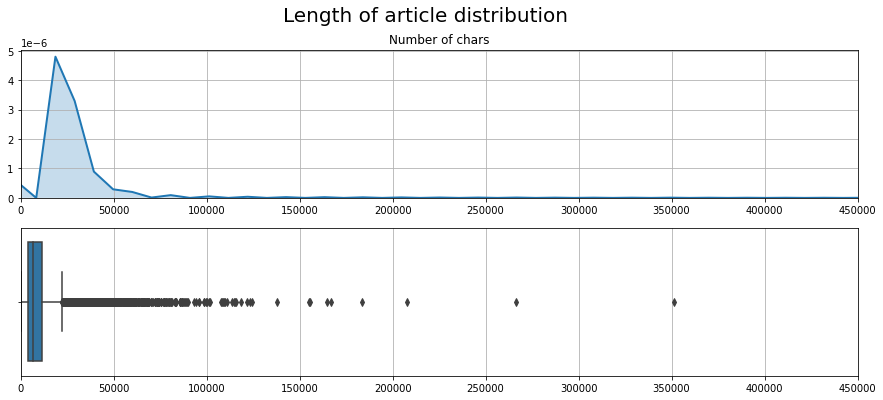

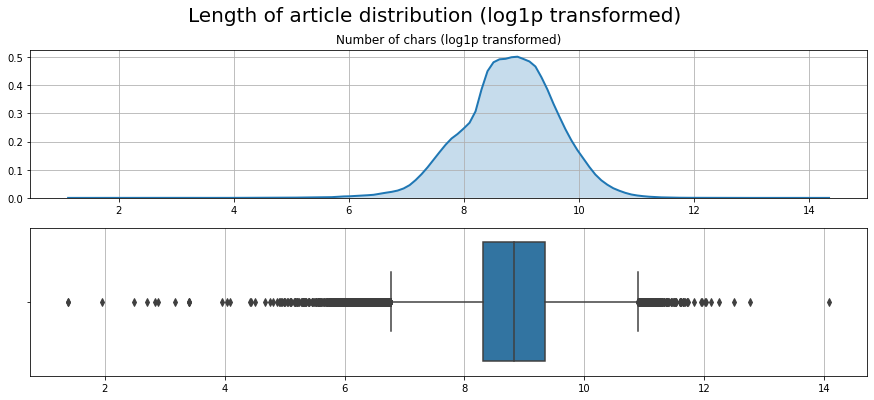

In [ ]:
plt.figure(figsize=(15,6))
plt.suptitle("Length of article distribution",fontsize=20)
gridspec.GridSpec(2,1)

plt.subplot2grid((2,1),(0,0))
plt.xlim(0, 450000)
plt.grid(True)
sns.distplot(subsample.text_lenght.values, hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.title("Number of chars")

plt.subplot2grid((2,1),(1,0))
plt.xlim(0, 450000)
plt.grid(True)
sns.boxplot(subsample.text_lenght.values);

plt.figure(figsize=(15,6))
plt.suptitle("Length of article distribution (log1p transformed)",fontsize=20)
gridspec.GridSpec(2,1)

plt.subplot2grid((2,1),(0,0))
sns.distplot(np.log1p(subsample.text_lenght.values), hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.grid(True)
plt.title("Number of chars (log1p transformed)")

plt.subplot2grid((2,1),(1,0))
plt.grid(True)
sns.boxplot(np.log1p(subsample.text_lenght.values));

# 3. Baselines

In [ ]:
%%time
subsample['clean_text'] = subsample['text'].apply(pr.clean_text)

CPU times: user 1min 12s, sys: 7.4 s, total: 1min 20s
Wall time: 1min 20s


In [ ]:
%%time
subsample['lemmas'] = subsample['clean_text'].apply(pr.lemmatization)

CPU times: user 27min 14s, sys: 2.29 s, total: 27min 16s
Wall time: 27min 16s


In [ ]:
#subsample = pd.read_pickle("./subsample.pkl")

In [ ]:
subsample['lemmas'] = subsample['lemmas'].apply(str)

In [ ]:
y = subsample['rate'].values
text = subsample['text'].values.tolist()
title = subsample['title'].values.tolist()
clean_text = subsample['clean_text'].values.tolist()
lemmas = subsample['lemmas'].values
# удаление столбца с датой
subsample.reset_index(drop=True, inplace=True)
subsample.drop(['title', 'text', 'text_lenght', 'rate', 'clean_text', 'lemmas'], axis=1, inplace=True)

## 3.1. Simple baseline: raw text data + dummies


In [ ]:
subsample.columns

Index(['weekday', 'year', 'month', 'hour'], dtype='object')

In [ ]:
%%time

list_to_dums = ['weekday', 'year', 'month', 'hour']
dummies = pd.get_dummies(subsample, columns = list_to_dums, drop_first=True,
                            prefix=list_to_dums, sparse=False)

CPU times: user 29.2 ms, sys: 458 µs, total: 29.6 ms
Wall time: 31.1 ms


In [ ]:
X_train_feats, X_test_feats, y_train, y_test = train_test_split(
    dummies, y, test_size=0.3, random_state=42, shuffle = False)

text_train, text_test = train_test_split(
    text, test_size=0.3, random_state=42, shuffle = False)

title_train, title_test = train_test_split(
    title, test_size=0.3, random_state=42, shuffle = False)

print('TRAIN feats: {}'.format(X_train_feats.shape))
print('TEST feats: {}'.format(X_test_feats.shape))

TRAIN feats: (42739, 43)
TEST feats: (18318, 43)


### 3.1.1. Count Vectorizer


In [ ]:
%%time
cv_text = CountVectorizer(max_features=50000)

X_train_text = cv_text.fit_transform(text_train)
X_test_text = cv_text.transform(text_test)

print('TRAIN text: {}'.format(X_train_text.shape))
print('TEST text: {}'.format(X_test_text.shape))
del text_train, text_test
gc.collect()

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 1min 13s, sys: 2.28 s, total: 1min 15s
Wall time: 1min 15s


#### 3.1.1.1. Ridge Regression


Обучение исключительно на текстах


In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_text, y_train)
y_pred = ridge.predict(X_test_text)

CPU times: user 14min 12s, sys: 10min 3s, total: 24min 16s
Wall time: 12min 20s


In [ ]:
print("MAE for raw texts and ridge regression:", mean_absolute_error(y_test, y_pred))

MAE for raw texts and ridge regression: 43.29201394357311


Обучение на текстах и категориальных переменных

In [ ]:
%%time

X_train_sparse = csr_matrix(hstack([X_train_text, X_train_feats.values])) 
X_test_sparse = csr_matrix(hstack([X_test_text, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_sparse, y_train)
y_pred = ridge.predict(X_test_sparse)

CPU times: user 15min 1s, sys: 10min 22s, total: 25min 24s
Wall time: 12min 51s


In [ ]:
mean_absolute_error(y_test, y_pred)

42.895550866691565

##### 3.1.1.1.1  Feature importance

In [ ]:
top30_plus = np.argsort(ridge.coef_)[-30:][::-1]
top30_plus

array([48176, 23448, 14283, 32483, 31366, 31703, 35825, 17459, 19641,
       24408, 31030, 33585, 17245, 11924, 32077,  1101, 46889, 16738,
       16106, 31694, 20902, 16280,  7803, 26412, 21718, 49842, 47844,
       26176, 28935, 14096])

In [ ]:
top30_minus = np.argsort(ridge.coef_)[:30]
top30_minus


array([23545, 29447, 38076, 22676, 27312,  5839, 44475, 30401, 30411,
       46397, 20090, 46478, 41831, 17253,  5990,  4336, 29720, 33199,
        6584,  7042, 13876, 25023, 42342, 48539, 33299, 40785,  9794,
       34933, 44751, 49979])

In [ ]:
feats_plus=[]
feats_minus=[]
for idx in top30_plus:
    if idx<X_train_text.shape[1]:
        feats_plus.append(list(cv_text.vocabulary_.keys())[list(cv_text.vocabulary_.values()).index(idx)])
for idx in top30_minus:
    if idx<X_train_text.shape[1]:
        feats_minus.append(list(cv_text.vocabulary_.keys())[list(cv_text.vocabulary_.values()).index(idx)])

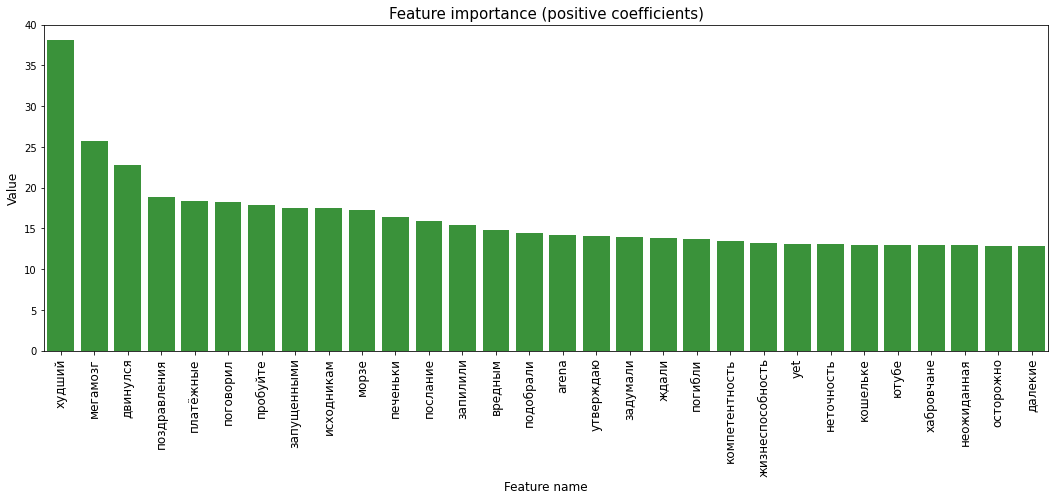

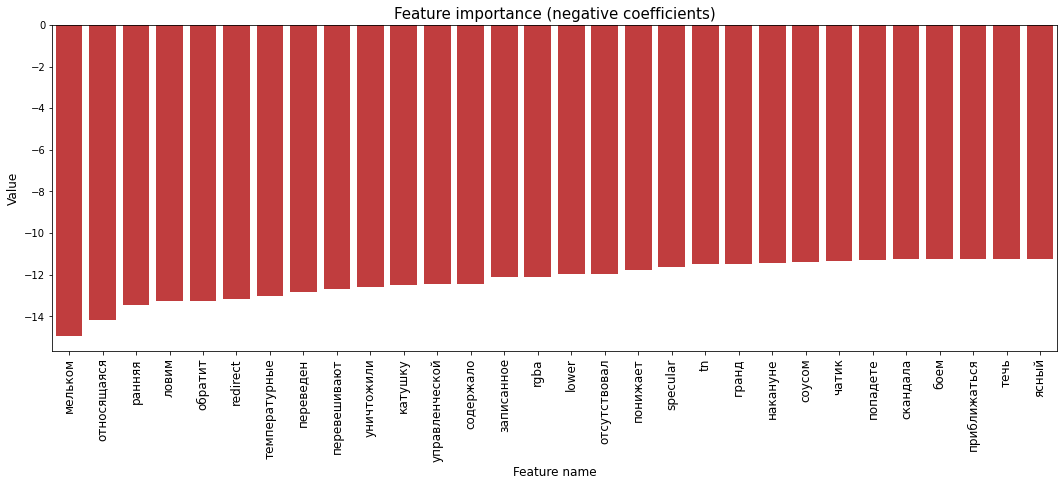

In [ ]:
plt.figure(figsize=(18,6))
ax1 = sns.barplot(feats_plus,ridge.coef_[top30_plus],color=color[2])
plt.ylabel('Value', fontsize=12)
plt.xlabel('Feature name', fontsize=12)
plt.title('Feature importance (positive coefficients)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=90, fontsize=12)
    
plt.figure(figsize=(18,6))
ax2 = sns.barplot(feats_minus,ridge.coef_[top30_minus],color=color[3])
plt.ylabel('Value', fontsize=12)
plt.xlabel('Feature name', fontsize=12)
plt.title('Feature importance (negative coefficients)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=90, fontsize=12);

#### 3.1.1.2. Linear Regression

Обучение на текстах и категориальных переменных

In [ ]:
%%time

LR = LinearRegression()
LR.fit(X_train_text, y_train)
y_pred = LR.predict(X_test_text)

CPU times: user 1h 34min 9s, sys: 1h 6min 52s, total: 2h 41min 2s
Wall time: 1h 21min 25s


In [ ]:
print("MAE for raw texts and linear regression:", mean_absolute_error(y_test, y_pred))

MAE for raw texts and linear regression: 264.10340346505126




## 3.2. Baseline: cleared text + dummies


In [ ]:
subsample.columns

Index(['weekday', 'year', 'month', 'hour'], dtype='object')

In [ ]:
%%time

list_to_dums = ['weekday', 'year', 'month', 'hour']
dummies = pd.get_dummies(subsample, columns = list_to_dums, drop_first=True,
                            prefix=list_to_dums, sparse=False)

CPU times: user 19.5 ms, sys: 1.03 ms, total: 20.5 ms
Wall time: 22.5 ms


In [ ]:
X_train_feats, X_test_feats, y_train, y_test = train_test_split(
    dummies, y, test_size=0.3, random_state=42, shuffle = False)

clean_text_train, clean_text_test = train_test_split(
    clean_text, test_size=0.3, random_state=42, shuffle = False)

print('TRAIN feats: {}'.format(X_train_feats.shape))
print('TEST feats: {}'.format(X_test_feats.shape))

TRAIN feats: (42739, 43)
TEST feats: (18318, 43)


### 3.2.1. Count Vectorizer

In [ ]:
%%time
cv_clean_text = CountVectorizer(max_features=50000)

X_train_clean_text = cv_clean_text.fit_transform(clean_text_train)
X_test_clean_text = cv_clean_text.transform(clean_text_test)

print('TRAIN text: {}'.format(X_train_clean_text.shape))
print('TEST text: {}'.format(X_test_clean_text.shape))

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 1min 9s, sys: 989 ms, total: 1min 10s
Wall time: 1min 10s


#### 3.2.1.1. Ridge Regression

Обучение исключительно на текстах

In [ ]:
#train test split: shuffle = False
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_clean_text, y_train)
y_pred = ridge.predict(X_test_clean_text)

CPU times: user 13min 44s, sys: 9min 37s, total: 23min 21s
Wall time: 11min 52s


In [ ]:
print("MAE for clean texts and ridge regression, shuffle=False:", mean_absolute_error(y_test, y_pred))

MAE for clean texts and ridge regression, shuffle=False: 41.8437363300904


In [ ]:
%%time

X_train_sparse = csr_matrix(hstack([X_train_clean_text, X_train_feats.values])) 
X_test_sparse = csr_matrix(hstack([X_test_clean_text, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

(42739, 50043) (18318, 50043)
CPU times: user 1.4 s, sys: 12.4 ms, total: 1.41 s
Wall time: 1.41 s


Обучение на текстах и категориальных переменных


In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_sparse, y_train)
y_pred = ridge.predict(X_test_sparse)

CPU times: user 13min 36s, sys: 9min 28s, total: 23min 5s
Wall time: 11min 55s


In [ ]:
print("MAE for clean texts, dummies and ridge regression, shuffle=False:", mean_absolute_error(y_test, y_pred))

MAE for clean texts, dummies and ridge regression, shuffle=False: 41.51842543685178


### 3.2.2. TF-IDF Vectorizer

In [ ]:
%%time
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2))

X_train_clean_text_tfidf = tfidf.fit_transform(clean_text_train)
X_test_clean_text_tfidf = tfidf.transform(clean_text_test)

print('TRAIN text: {}'.format(X_train_clean_text_tfidf.shape))
print('TEST text: {}'.format(X_test_clean_text_tfidf.shape))

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 6min 31s, sys: 6.44 s, total: 6min 37s
Wall time: 6min 38s


In [ ]:
#X_train_clean_text_tfidf = sparse.load_npz("X_train_clean_text_tfidf.npz")
#X_test_clean_text_tfidf = sparse.load_npz("X_test_clean_text_tfidf.npz")

In [ ]:
%%time

X_train_sparse = csr_matrix(hstack([X_train_clean_text_tfidf, X_train_feats.values])) 
X_test_sparse = csr_matrix(hstack([X_test_clean_text_tfidf, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

(42739, 50043) (18318, 50043)
CPU times: user 3.42 s, sys: 310 ms, total: 3.73 s
Wall time: 3.75 s


#### 3.2.2.1. Ridge Regression

In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_sparse, y_train)
y_pred = ridge.predict(X_test_sparse)

CPU times: user 28.7 s, sys: 17.8 s, total: 46.5 s
Wall time: 25.3 s


In [ ]:
print("MAE for clean texts, dummies and ridge regression, shuffle=False:", mean_absolute_error(y_test, y_pred))

MAE for clean texts, dummies and ridge regression, shuffle=False: 16.392798649660655


#### 3.2.2.2. LightGBM

In [ ]:
param = {'num_trees': 100000, 'application':'regression',
         'learning_rate': 0.01, 'num_threads': 7, 'max_depth': 10,
         'lambda_l2': 1e-3}
param['metric'] = 'mae'

In [ ]:
train_data = lgb.Dataset(X_train_sparse, label=y_train)
test_data = train_data.create_valid(X_test_sparse, label=y_test)

In [ ]:
%%time 
bst = lgb.train(param, train_data, param['num_trees'], valid_sets=[test_data], early_stopping_rounds=50)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_trees` in params. Will use it instead of argument



[1]	valid_0's l1: 15.7048
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l1: 15.6891
[3]	valid_0's l1: 15.6733
[4]	valid_0's l1: 15.6584
[5]	valid_0's l1: 15.6434
[6]	valid_0's l1: 15.6308
[7]	valid_0's l1: 15.6156
[8]	valid_0's l1: 15.6025
[9]	valid_0's l1: 15.5884
[10]	valid_0's l1: 15.5763
[11]	valid_0's l1: 15.563
[12]	valid_0's l1: 15.5523
[13]	valid_0's l1: 15.5384
[14]	valid_0's l1: 15.5274
[15]	valid_0's l1: 15.5145
[16]	valid_0's l1: 15.504
[17]	valid_0's l1: 15.4914
[18]	valid_0's l1: 15.4814
[19]	valid_0's l1: 15.4701
[20]	valid_0's l1: 15.4599
[21]	valid_0's l1: 15.4492
[22]	valid_0's l1: 15.4408
[23]	valid_0's l1: 15.4295
[24]	valid_0's l1: 15.4203
[25]	valid_0's l1: 15.4108
[26]	valid_0's l1: 15.3986
[27]	valid_0's l1: 15.3878
[28]	valid_0's l1: 15.3763
[29]	valid_0's l1: 15.3679
[30]	valid_0's l1: 15.3604
[31]	valid_0's l1: 15.3504
[32]	valid_0's l1: 15.3411
[33]	valid_0's l1: 15.3333
[34]	valid_0's l1: 15.3246
[35]	valid_0's l1: 15.3145
[36]

## 3.3. Baseline: lemmas + dummies

In [ ]:
subsample.columns

Index(['weekday', 'year', 'month', 'hour'], dtype='object')

In [ ]:
%%time

list_to_dums = ['weekday', 'year', 'month', 'hour']
dummies = pd.get_dummies(subsample, columns = list_to_dums, drop_first=True,
                            prefix=list_to_dums, sparse=False)

CPU times: user 22.7 ms, sys: 888 µs, total: 23.5 ms
Wall time: 30.3 ms


In [ ]:
X_train_feats, X_test_feats, y_train, y_test = train_test_split(
    dummies, y, test_size=0.3, random_state=42, shuffle = False)

In [ ]:
X_train_lemmas, X_test_lemmas, y_train, y_test = train_test_split(
  lemmas, y, test_size=0.3, random_state=42, shuffle = False)

print('TRAIN: {}'.format(X_train_lemmas.shape))
print('TEST: {}'.format(X_test_lemmas.shape))

TRAIN: (42739,)
TEST: (18318,)


### 3.3.1. Count Vectorizer

In [ ]:
%%time
cv_lemmas = CountVectorizer(max_features=50000)

X_train_lemmas_cv = cv_lemmas.fit_transform()
X_test_lemmas_cv = cv_clean_text.transform(clean_text_test)

print('TRAIN text: {}'.format(X_train_lemmas_cv.shape))
print('TEST text: {}'.format(X_test_lemmas_cv.shape))

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 1min 6s, sys: 560 ms, total: 1min 6s
Wall time: 1min 6s


#### 3.3.1.1. Ridge Regression

In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_lemmas_cv, y_train)
y_pred_lemmas = ridge.predict(X_test_lemmas_cv)

CPU times: user 13min 24s, sys: 9min 25s, total: 22min 49s
Wall time: 11min 35s


In [ ]:
print("MAE for lemmas and ridge regression:", mean_absolute_error(y_test, y_pred_lemmas))

MAE for lemmas and ridge regression: 41.8437363300904


In [ ]:
%%time

X_train_lemmas_sparse = csr_matrix(hstack([X_train_lemmas_cv, X_train_feats.values])) 
X_test_lemmas_sparse = csr_matrix(hstack([X_test_lemmas_cv, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

(42739, 50043) (18318, 50043)
CPU times: user 1.16 s, sys: 1.33 s, total: 2.48 s
Wall time: 2.52 s


In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_lemmas_sparse, y_train)
y_pred_lemmas = ridge.predict(X_test_lemmas_sparse)

CPU times: user 13min 33s, sys: 9min 29s, total: 23min 2s
Wall time: 11min 49s


In [ ]:
print("MAE for lemmas, dummies and ridge regression:", mean_absolute_error(y_test, y_pred_lemmas))

MAE for lemmas, dummies and ridge regression: 41.51842543685178


### 3.3.2. TF-IDF Vectorizer

In [ ]:
%%time
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2))

X_train_lemmas_tfidf = tfidf.fit_transform(X_train_lemmas)
X_test_lemmas_tfidf = tfidf.transform(X_test_lemmas)

print('TRAIN lemmas: {}'.format(X_train_lemmas_tfidf.shape))
print('TEST lemmas: {}'.format(X_test_lemmas_tfidf.shape))

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 3min 30s, sys: 4.09 s, total: 3min 34s
Wall time: 3min 34s


In [ ]:
#X_train_lemmas_tfidf = sparse.load_npz("X_train_lemmas_tfidf.npz")
#X_test_lemmas_tfidf = sparse.load_npz("X_test_lemmas_tfidf.npz")

In [ ]:
%%time

X_train_sparse = csr_matrix(hstack([X_train_lemmas_tfidf, X_train_feats.values])) 
X_test_sparse = csr_matrix(hstack([X_test_lemmas_tfidf, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

(42739, 50043) (18318, 50043)
CPU times: user 2.34 s, sys: 69.8 ms, total: 2.41 s
Wall time: 2.41 s


#### 3.3.2.1. Ridge Regression

In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_sparse, y_train)
y_pred_lemmas = ridge.predict(X_test_sparse)

CPU times: user 33.5 s, sys: 19.4 s, total: 52.9 s
Wall time: 30.3 s


In [ ]:
print("MAE for lemmas, dummies and ridge regression:", mean_absolute_error(y_test, y_pred_lemmas))

MAE for lemmas, dummies and ridge regression: 16.982229088808964


#### 3.3.2.2. LightGBM

In [ ]:
param = {'num_trees': 100000, 'application':'regression',
         'learning_rate': 0.01, 'num_threads': 7, 'max_depth': 10,
         'lambda_l2': 1e-3}
param['metric'] = 'mae'

In [ ]:
train_data = lgb.Dataset(X_train_sparse, label=y_train)
test_data = train_data.create_valid(X_test_sparse, label=y_test)

In [ ]:
%%time 
bst = lgb.train(param, train_data, param['num_trees'], valid_sets=[test_data], early_stopping_rounds=50)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_trees` in params. Will use it instead of argument



[1]	valid_0's l1: 15.7069
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l1: 15.6934
[3]	valid_0's l1: 15.6801
[4]	valid_0's l1: 15.6669
[5]	valid_0's l1: 15.654
[6]	valid_0's l1: 15.643
[7]	valid_0's l1: 15.6307
[8]	valid_0's l1: 15.6201
[9]	valid_0's l1: 15.6082
[10]	valid_0's l1: 15.5979
[11]	valid_0's l1: 15.5859
[12]	valid_0's l1: 15.5725
[13]	valid_0's l1: 15.5613
[14]	valid_0's l1: 15.552
[15]	valid_0's l1: 15.5416
[16]	valid_0's l1: 15.5324
[17]	valid_0's l1: 15.5225
[18]	valid_0's l1: 15.514
[19]	valid_0's l1: 15.5041
[20]	valid_0's l1: 15.4935
[21]	valid_0's l1: 15.4854
[22]	valid_0's l1: 15.4755
[23]	valid_0's l1: 15.465
[24]	valid_0's l1: 15.4545
[25]	valid_0's l1: 15.4462
[26]	valid_0's l1: 15.4387
[27]	valid_0's l1: 15.432
[28]	valid_0's l1: 15.4252
[29]	valid_0's l1: 15.4181
[30]	valid_0's l1: 15.4085
[31]	valid_0's l1: 15.4008
[32]	valid_0's l1: 15.3912
[33]	valid_0's l1: 15.3816
[34]	valid_0's l1: 15.3753
[35]	valid_0's l1: 15.3656
[36]	val

# 4. Anomaly detection

## 4.1. Prophet

In [56]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

### 4.1.1. Prepearing data

Суммарный рейтинг за каждый месяц

In [57]:
rating_monthly_df = pd.DataFrame(subsample.rate.resample('M').sum())

In [58]:
rating_monthly_df.head()

,rate
date,
2016-01-31,22345
2016-02-29,23477
2016-03-31,26360
2016-04-30,23774
2016-05-31,22018


In [59]:
rating_monthly_df['ds'] = rating_monthly_df.index
rating_monthly_df.reset_index(drop=True, inplace=True)

In [60]:
rating_monthly_df.columns = ['y', 'ds']

Суммарный рейтинг за каждую неделю

In [61]:
rating_weekly_df = pd.DataFrame(subsample.rate.resample('W').sum())

In [62]:
rating_weekly_df.head()

,rate
date,
2016-01-03,975
2016-01-10,3627
2016-01-17,5990
2016-01-24,5420
2016-01-31,6333


In [63]:
rating_weekly_df['ds'] = rating_weekly_df.index
rating_weekly_df.reset_index(drop=True, inplace=True)

In [64]:
rating_weekly_df.columns = ['y', 'ds']

Суммарный рейтинг за каждый день

In [65]:
rating_daily_df = pd.DataFrame()
rating_daily_df['rate'] = subsample.rate.resample('D').sum()
rating_daily_df.head()

,rate
date,
2016-01-01,231
2016-01-02,285
2016-01-03,459
2016-01-04,542
2016-01-05,608


In [66]:
rating_daily_df['ds'] = rating_daily_df.index
rating_daily_df.reset_index(drop=True, inplace=True)

In [67]:
rating_daily_df.head()

,rate,ds
0,231,2016-01-01
1,285,2016-01-02
2,459,2016-01-03
3,542,2016-01-04
4,608,2016-01-05


In [68]:
rating_daily_df.columns = ['y', 'ds']

### 4.1.2. Forecasting

Используем в модели следующие параметры:
* growth - тип тренда
* yearly_seasonality - годовая сезонность
* weekly_seasonality - недельная сезонность
* праздничные дни
* changepoint_range - доля исторических данных (начиная с самого первого наблюдения), в пределах которых будут оценены точки излома тренда
* seasonality_mode - режим моделирования сезонных компонентов
* interval_width - число, определяющее ширину доверительного интервала для предсказанных моделью значений


#### 4.1.2.1. Overall rating weekly


Displaying Prophet plot
CPU times: user 2.21 s, sys: 117 ms, total: 2.32 s
Wall time: 2.31 s


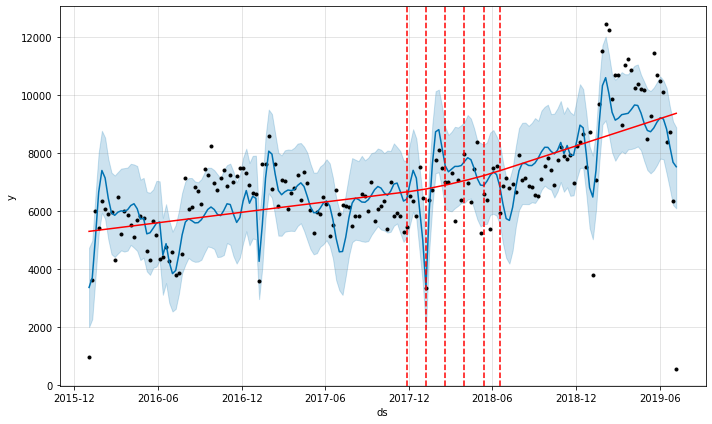

In [69]:
%%time


def fit_predict_model(dataframe, interval_width = 0.8, changepoint_range = 0.8):
    
    m = Prophet(daily_seasonality = False, growth = 'linear', yearly_seasonality = 'auto', weekly_seasonality = False,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m.add_country_holidays(country_name='RU')
    m = m.fit(dataframe) 
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    a = add_changepoints_to_plot(fig1.gca(), m, forecast)
    return forecast
    
pred = fit_predict_model(rating_weekly_df)

* Черные точки соответствуют значениям отклика из обучающей выборки 
* Сплошная голубая линия - это предсказанные моделью значения отклика
* Огибающая эту линию светло-голубая "лента" - это 80% доверительные интервалы соответствующих предсказанных значений 
* Сплошная красная линия - тренд, оцененный с помощью модели
* Штриховые красные линии - оцененные точки излома тренда

Увеличим  интервал до 90%, воспользовавшись аргументом changepoint_range. Также явно зададим количество потенциальных точек излома.

Displaying Prophet plot
CPU times: user 2.09 s, sys: 71.3 ms, total: 2.16 s
Wall time: 2.14 s


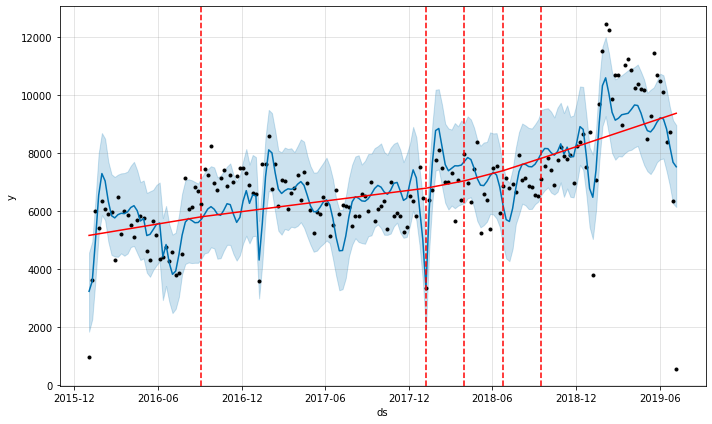

In [70]:
%%time


def fit_predict_model(dataframe, interval_width = 0.8, changepoint_range = 0.9):
    
    m = Prophet(daily_seasonality = False, growth = 'linear', yearly_seasonality = 'auto', weekly_seasonality = False,
                n_changepoints=14,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m.add_country_holidays(country_name='RU')
    m = m.fit(dataframe) 
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    a = add_changepoints_to_plot(fig1.gca(), m, forecast)
    return forecast
    
pred = fit_predict_model(rating_weekly_df)

Видно, что с изменением конфигурации модель стала лучше определять точки излома тренда.

### 4.1.3. Plotting

Будем считать аномалией любую точку, которая  находится за границами (то есть выше или ниже) 80%-го доверительного интервала. Важность аномалии определяется расстоянием от нее до границ доверительного интервала.

In [71]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [72]:
import altair as alt

In [74]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
   ).interactive().properties(
   #).properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=1000, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

alt.LayerChart(...)

# Итоги

Необходимо было построить модель для прогнозирования рейтинга статьи на ресурсе https://habr.com. В ходе выполнения задачи был произведен разведочный анализ данных, препроцессинг и обучение моделей, а также оценка результатов обучения.


На этапе препроцессинга использовались очистка текста и лемматизация. Лемматизация производилась с помощью библиотеки pymorphy2. 
Для векторизации слов использовались Count Vectorizer, TF-IDF Vectorizer.

Добавленные признаки: weekday, year, month, hour, text_lenght.

Используемые модели: Ridge Regression, Linear Regression, LightGBM.

Используемая метрика - MAE (средняя абсолютная ошибка).

Получены следующие результаты:
1. Тексты без предобработки:
    * Count Vectorizer + Ridge Regression: 43.29201394357311
    * Count Vectorizer + Linear Regression: 264.10340346505126


2. Очищенные тексты :
    - Count Vectorizer + Ridge Regression 41.8437363300904
    - Count Vectorizer + categorical variables + Ridge Regression: 41.51842543685178
    - TF-IDF Vectorizer + categorical variables + Ridge Regression: 16.392798649660655
    - TF-IDF Vectorizer + categorical variables + LightGBM: 14.1602
3. Леммы:
    - Count Vectorizer and ridge regression: 41.8437363300904
    - TF-IDF Vectorizer + categorical variables + Ridge Regression: 16.982229088808964
    - TF-IDF Vectorizer + categorical variables + LightGBM: 14.099 

Наилучшие результаты показали следующие бейзлайны:
1. Lemmas + TF-IDF Vectorizer + categorical variables + LightGBM: 14.099
2. Clean text + TF-IDF Vectorizer + categorical variables + LightGBM: 14.1602

Идеи для улучшения:
- feature engineering: добавить другие признаки. Так как датасет изначально был очищен от html-тегов, тегов для статей на хабре, а также не было данных об авторе, то можно было бы использовать эти данные. Например, добавить признак с количеством тегов статьи или, используя html-теги, подсчитать для каждой статьи количество видео/ссылок/изображений. 
- Использовать другие word embeddings: Word2Vec, GloVe, fastText.
- Использовать более сложные модели, например, LSTM.
- Блендинг моделей.
